In [1]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)

In [2]:
from brio.data_processing.Preprocessing import Preprocessing
from brio.ml_models.BinaryClassificationTraining import BinaryClassificationTraining 

import mlflow
import os
from sklearn.model_selection import train_test_split
import json
from pickle import dump, load
import numpy as np
import pandas as pd
from hyperopt import fmin, tpe, Trials, STATUS_OK, hp, space_eval
from functools import partial

from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_lift_curve

In [3]:
with open("../data/raw_data/uci-default-of-credit-card/datapackage.json", "rb") as file:
    data_dictionary = json.load(file)

In [4]:
data_dictionary['description'].split("X")[3:]

['1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.',
 '2: Gender (1 = male; 2 = female).',
 '3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).',
 '4: Marital status (1 = married; 2 = single; 3 = others).',
 '5: Age (year).',
 '6 - ',
 '11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: ',
 '6 = the repayment status in September, 2005; ',
 '7 = the repayment status in August, 2005; . . .;',
 '11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.',
 '12-',
 '17: Amount of bill statement (NT dollar). ',
 '12 = amount of bill statement in September, 2005; ',
 '13 = amount of bill statement in August, 2005;

In [8]:
input_data_path = "../data/raw_data/uci-default-of-credit-card/data/data.csv"
local_path_save = '../data/mlflow_artifacts/'

In [6]:
if not os.path.exists(local_path_save):
    os.makedirs(local_path_save)

#save all metadata in a sqlite db. Artifacts will be saved on local folder ./mlflow    
mlflow.set_tracking_uri("sqlite:///mlflow.db")

# Name of the experiment
exp_name = "Default_prediction_with_RandomForest"
# set up MlFlow axperiment
experiment_id = mlflow.set_experiment(exp_name)

## Preprocessing

In [9]:
pp = Preprocessing(input_data_path, "default")

In [10]:
X, Y = pp.read_dataframe()

In [11]:
X.head()

,id,x1_limit_bal,x2_sex,x3_education,x4_marriage,x5_age,x6_pay_0,x7_pay_2,x8_pay_3,x9_pay_4,...,x15_bill_amt4,x16_bill_amt5,x17_bill_amt6,x18_pay_amt1,x19_pay_amt2,x20_pay_amt3,x21_pay_amt4,x22_pay_amt5,x23_pay_amt6,y_default_payment_next_month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,True
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,True
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,False
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,False
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,False


In [12]:
X.columns

Index(['id', 'x1_limit_bal', 'x2_sex', 'x3_education', 'x4_marriage', 'x5_age',
       'x6_pay_0', 'x7_pay_2', 'x8_pay_3', 'x9_pay_4', 'x10_pay_5',
       'x11_pay_6', 'x12_bill_amt1', 'x13_bill_amt2', 'x14_bill_amt3',
       'x15_bill_amt4', 'x16_bill_amt5', 'x17_bill_amt6', 'x18_pay_amt1',
       'x19_pay_amt2', 'x20_pay_amt3', 'x21_pay_amt4', 'x22_pay_amt5',
       'x23_pay_amt6', 'y_default_payment_next_month'],
      dtype='object')

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=420)


#preprocessing ohe
shapes_pre = (X_train.shape[0], X_test.shape[0])
X_train_ohe, ohe, scaler = pp.preprocess_for_classification(df=X_train, fit_ohe=True, perform_scaling=True)
X_test_ohe, _, _ = pp.preprocess_for_classification(df=X_test, 
                                                    fit_ohe=True, 
                                                    fitted_ohe=ohe,
                                                    perform_scaling=True,
                                                    fitted_scaler=scaler)
assert shapes_pre == (X_train.shape[0], X_test.shape[0])

dump(ohe, open(local_path_save + '_ohe.pkl', 'wb'))
dump(scaler, open(local_path_save + '_scaler.pkl', 'wb'))

## Hyperparameters Optimization and Training

In [10]:
run_name = 'base'

In [11]:
random_forest_training = BinaryClassificationTraining(
    input_data_path,
    local_path_save,
    'random_forest')

In [12]:
# Calculating the baseline
random_forest_training.calculate_classification_baseline(Y_train=Y_train, Y_test=Y_test, run_name=run_name)

/Users/davideposillipo/.pyenv/versions/3.10.9/envs/prova/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davideposillipo/.pyenv/versions/3.10.9/envs/prova/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'loss': 0.5, 'status': 'ok'}

In [13]:
# Fixed depth, varying number of trees
run_name = "trial_1"

for B in np.arange(10,600,100, dtype=int):
    
    max_evals = 1
                   
    # Here we can decide which hyperparameters we want to tune
    rf_parameters_search = {
        'n_estimators': B,
        'max_depth': 5
    }

    random_forest_training.set_hyperparameter_space(rf_parameters_search)
                   
    trials = Trials()

    best_result = fmin(
        fn=partial(random_forest_training.objective_random_forest, 
            X_train=X_train_ohe,
            X_test=X_test_ohe,
            Y_train=Y_train,
            Y_test=Y_test,
            run_name=run_name,
            threshold=0.5),
        space=random_forest_training.hp_space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials,
        rstate=np.random.default_rng(420)
    )

    best_result

  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

/Users/davideposillipo/.pyenv/versions/3.10.9/envs/prova/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



100%|██████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.87s/trial, best loss: 0.7668380718437293]


In [14]:
#Fixed number of trees, varying depth
run_name = "trial_2"

for d in np.arange(2,50,5, dtype=int):
    
    max_evals = 1
                   
    # Here we can decide which hyperparameters we want to tune
    rf_parameters_search = {
        'n_estimators': 200,
        'max_depth': d
    }

    random_forest_training.set_hyperparameter_space(rf_parameters_search)
                   
    trials = Trials()

    best_result = fmin(
        fn=partial(random_forest_training.objective_random_forest, 
            X_train=X_train_ohe,
            X_test=X_test_ohe,
            Y_train=Y_train,
            Y_test=Y_test,
            run_name=run_name,
            threshold=0.5),
        space=random_forest_training.hp_space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials,
        rstate=np.random.default_rng(420)
    )

    best_result

100%|██████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.04s/trial, best loss: 0.7651810395984063]


## Inference

#### With MLFlow functionalities

In [32]:
# the URI 
logged_model = 'runs:/1e4a0667c7a64cbe8c7b023410e5781c/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
loaded_model.predict(pd.DataFrame(X_test_ohe))

array([0, 1, 0, ..., 0, 1, 0])

#### Using the sklearn object directly

In [37]:
with open("mlruns/1/1e4a0667c7a64cbe8c7b023410e5781c/artifacts/model/model.pkl", "rb") as file:
    winning_model = load(file)

In [38]:
winning_model

RandomForestClassifier(max_depth=12, n_estimators=200)

In [56]:
fi = pd.DataFrame([pd.Series(winning_model.feature_importances_), pd.Series(winning_model.feature_names_in_)])
fi.T.rename(columns={1:"feature", 0:"importance"}).sort_values('importance', ascending=False)[0:20]

,importance,feature
31,0.137158,x6_pay_0_2
42,0.062741,x7_pay_2_2
0,0.04363,x1_limit_bal
8,0.040919,x18_pay_amt1
64,0.040456,x9_pay_4_2
2,0.038592,x12_bill_amt1
53,0.03663,x8_pay_3_2
3,0.036425,x13_bill_amt2
9,0.035265,x19_pay_amt2
4,0.035244,x14_bill_amt3


In [50]:
predicted_prob = winning_model.predict_proba(X_test_ohe)
predicted_values = winning_model.predict(X_test_ohe)

## Diagnostic Plots

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

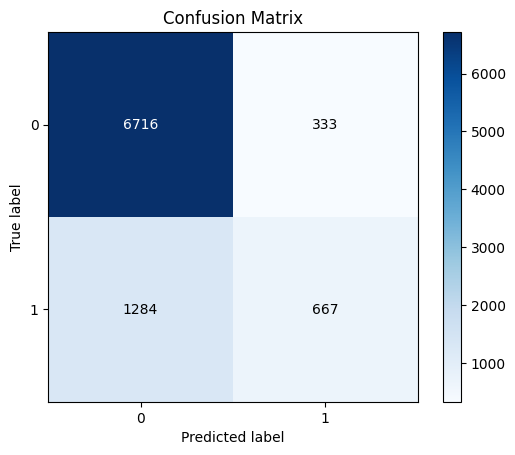

In [51]:
plot_confusion_matrix(Y_test, predicted_values)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

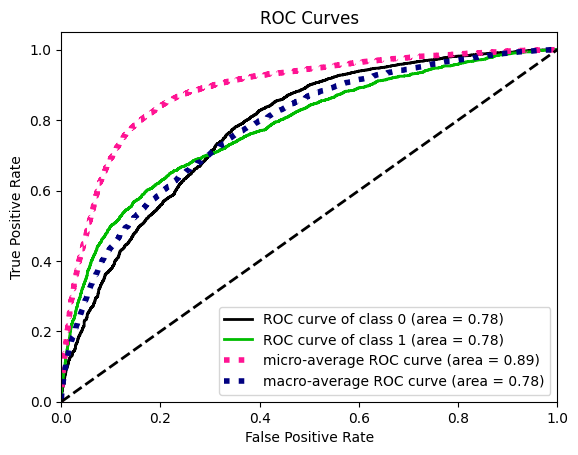

In [53]:
plot_roc(Y_test, predicted_prob)

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

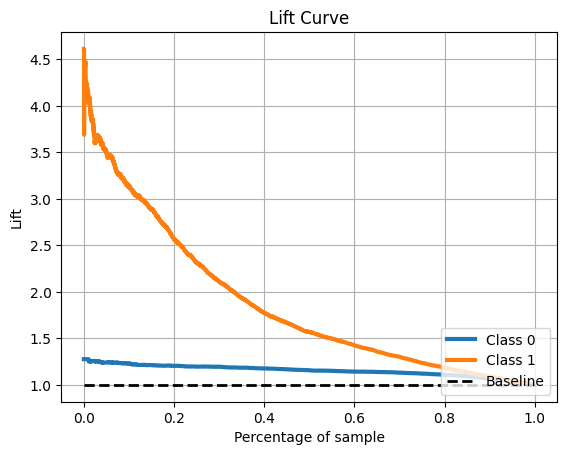

In [55]:
plot_lift_curve(Y_test, predicted_prob)